In this notebook, I will plot four distributions:

1. Ideal normal distributions;
2. Ideal non-normal distributions; 
3. Empirical distribution when data is generated with the EBM framework. 
4. Empirical distribution when data is generated with the Sigmoid framework. 

In [1]:
from bebms.generate_data import very_irregular_distribution
from bebms import get_params_path
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import json 
import yaml
from bebms import generate

/home/hhao9/miniconda/envs/jobs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    "axes.titlesize": 13,
    "axes.labelsize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "figure.titlesize": 13
})

In [3]:
def load_config():
    config_path = "../config.yaml"
    with open(config_path, "r") as f:
        return yaml.safe_load(f)
config = load_config()
# print(json.dumps(config, indent=4))

In [4]:
rng = np.random.default_rng(config['GEN_SEED'])
params_file = '../adni_params_ucl_gmm.json'
with open(params_file, 'r') as f:
    biomarker_params = json.load(f)

In [5]:
for exp_name in config['EXPERIMENT_NAMES']: # first, change config.yaml to only get exp1 and exp6
    random_state = rng.integers(0, 2**32 - 1)
    generate(
        experiment_name = exp_name,
        # params_file=params_file,
        params=biomarker_params,
        js = [1000],
        rs = [0.25],
        num_of_datasets_per_combination=1,
        output_dir='sample_data',
        seed=random_state,
        keep_all_cols = True,
        temperature_lo=config['TEMPERATURE_LO'],
        temperature_hi=config['TEMPERATURE_HI'],
        n_sub_lo=config['N_SUB_LO'],
        n_sub_hi=config['N_SUB_HI'],
        subtype_dirichlet_priors=config['GEN_DIRICHLET_PRIORS'],
        subtype_length_lo=config['SUBTYPE_LENGTH_LO'],
        fixed_biomarker_order=True,
    )

Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/
Data generation complete. Files saved in sample_data/


In [6]:
sigmoid_df = pd.read_csv('sample_data/j1000_r0.25_Esn_kjContinuousBeta_sigmoid.csv')
sigmoid_df.head()

,participant,biomarker,measurement,diseased,event_time,k_j,affected
0,0,EntorhinalNorm,0.002057,True,4,9.269703,True
1,0,PTAU,-10.069461,True,3,9.269703,True
2,0,VentricleNorm,0.000460,True,2,9.269703,True
3,0,ABETA,817.486811,True,1,9.269703,True
4,0,MMSE,25.369985,True,8,9.269703,True


In [7]:
ebm_df = pd.read_csv('sample_data/j1000_r0.25_Esn_kjOrdinalDM_xnjNormal.csv')
ebm_df.head()

,participant,biomarker,measurement,diseased,event_time,k_j,affected
0,0,WholeBrainNorm,0.689420,True,8,8.0,True
1,0,EntorhinalNorm,0.002937,True,7,8.0,True
2,0,RAVLT_immediate,33.542542,True,6,8.0,True
3,0,TAU,245.769158,True,5,8.0,True
4,0,MidTempNorm,0.012906,True,9,8.0,False


In [8]:
def generate_irregular_samples(biomarker_params, biomarker, state):
    return very_irregular_distribution(
        biomarker=biomarker,
        bm_params=biomarker_params[biomarker],
        state=state,
        size=100000
    )

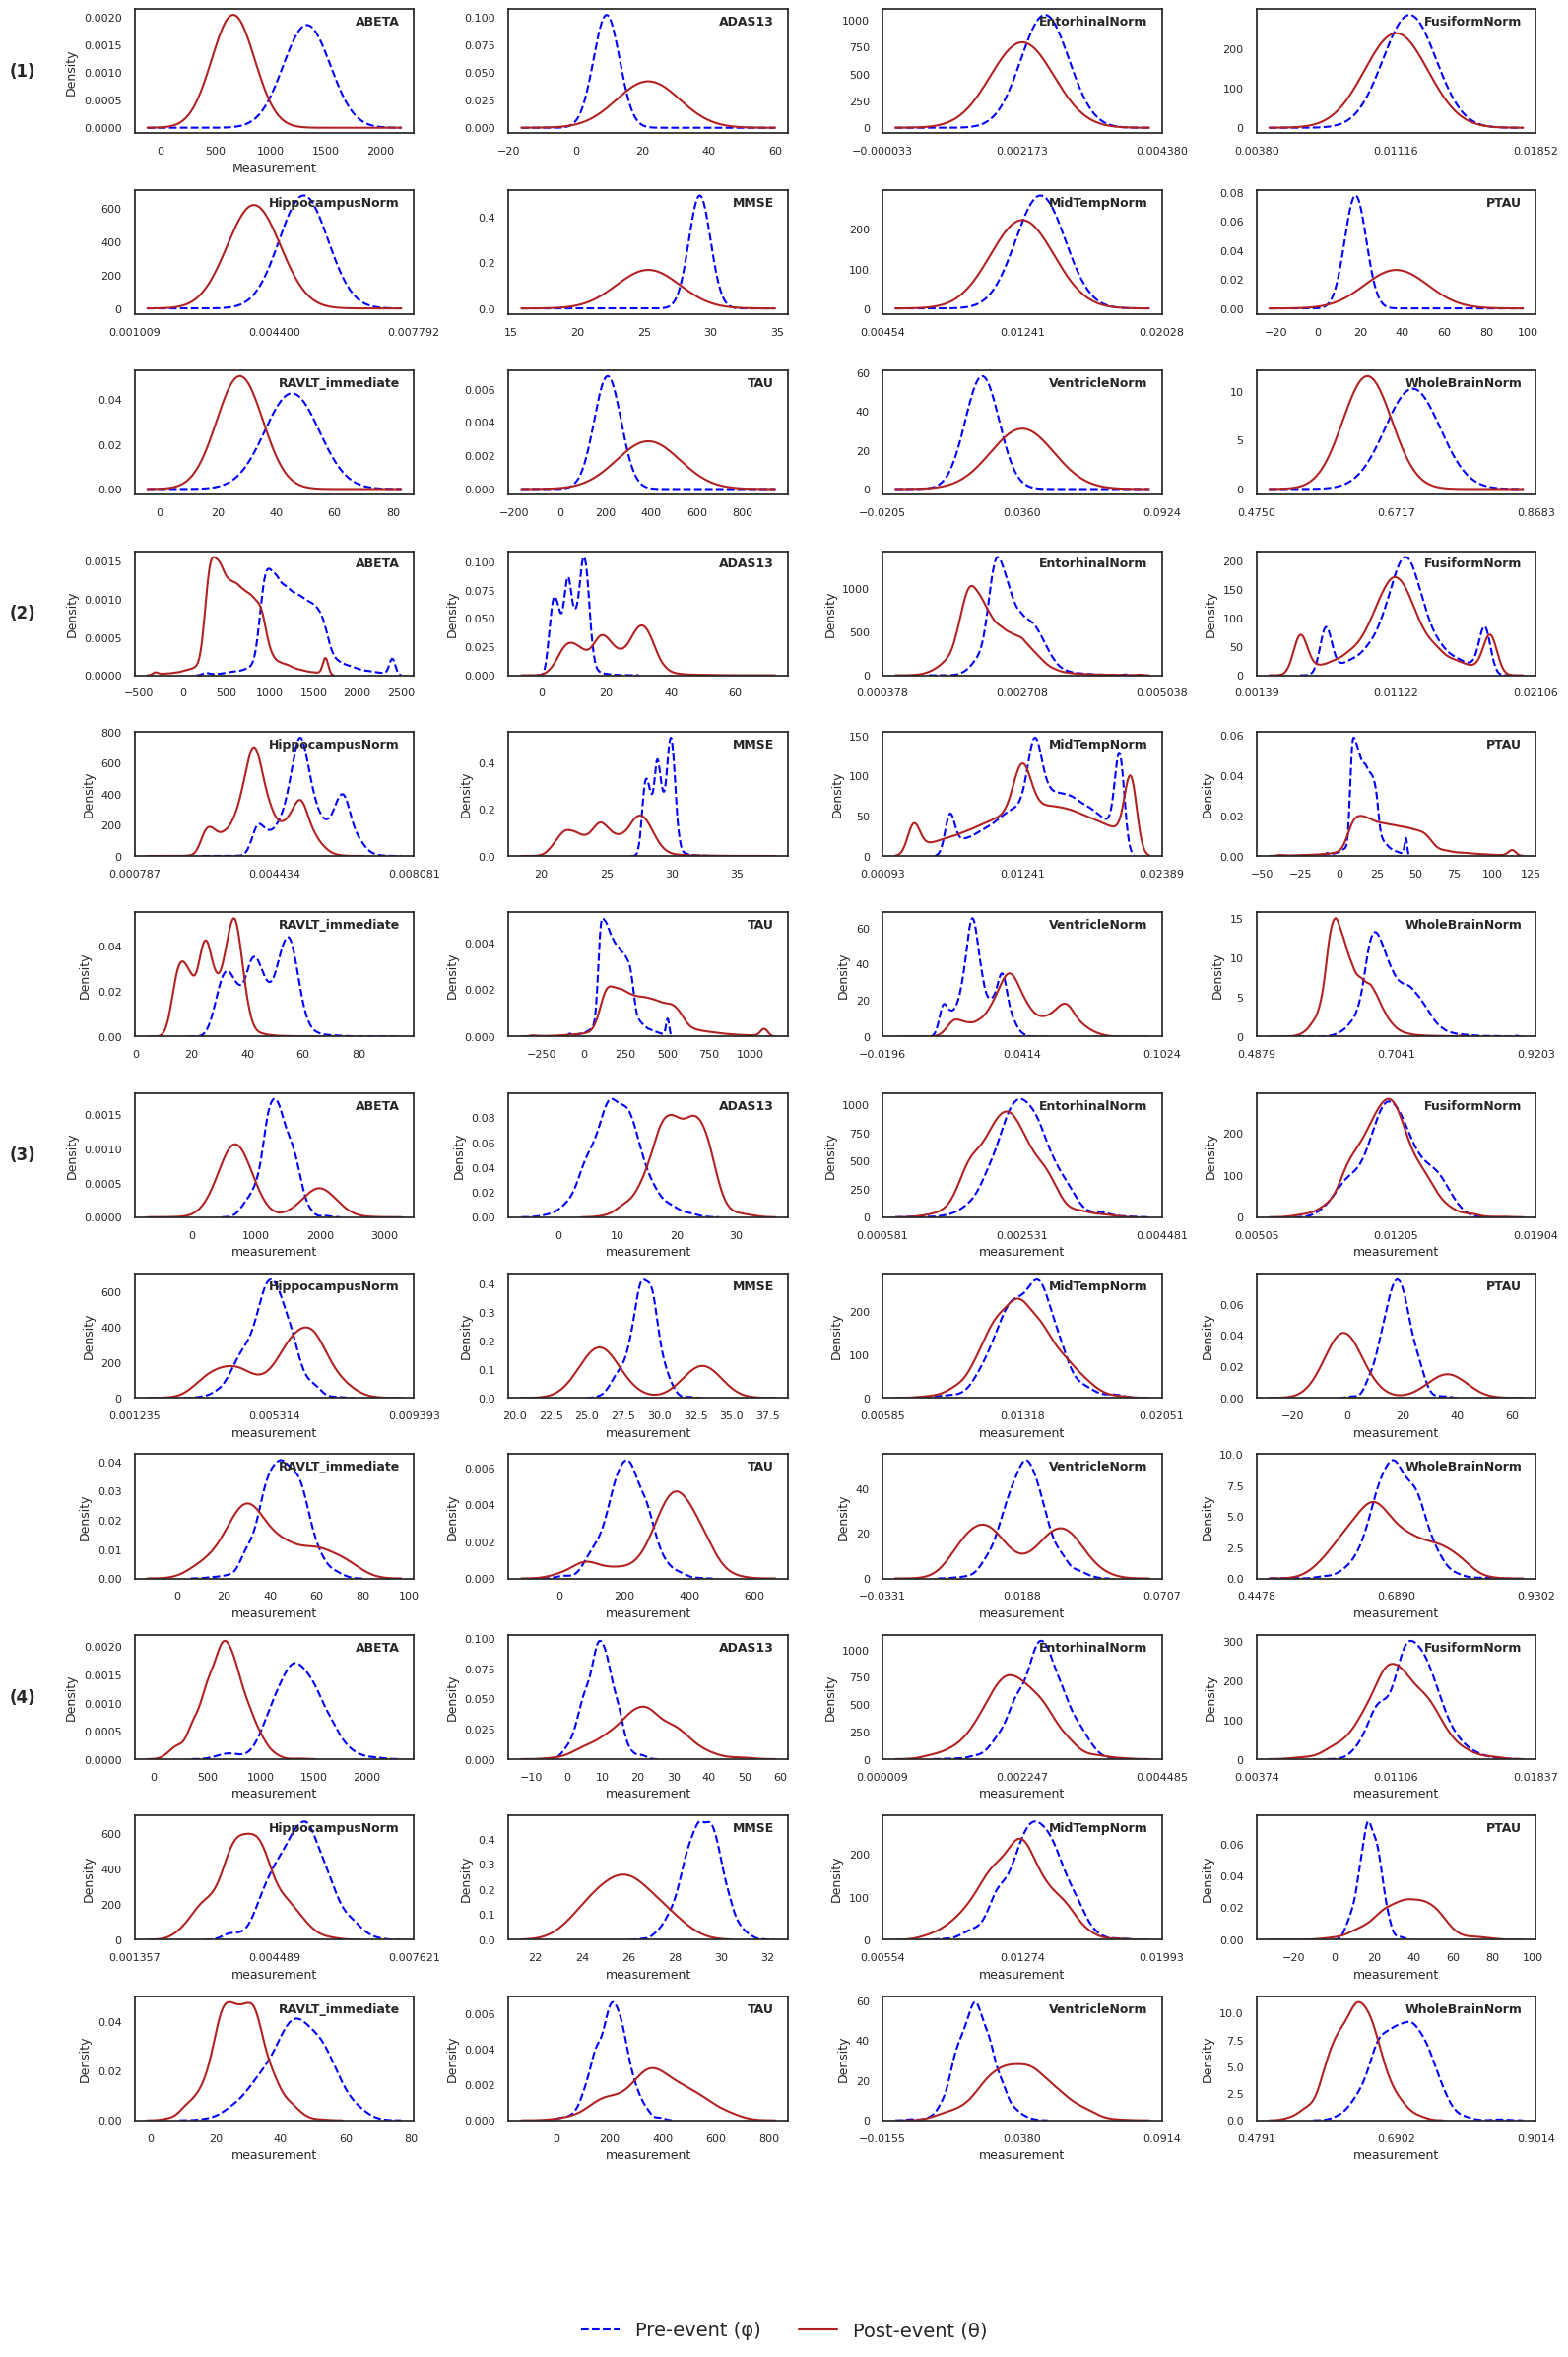

In [9]:
# --- Styling ---
sns.set(style="white")
plt.rcParams.update({
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "figure.titlesize": 12
})

# --- Setup ---
biomarkers = sorted(biomarker_params.keys())
n_rows, n_cols = 3, 4
n_panels = 4
fig, axs = plt.subplots(n_panels * n_rows, n_cols, figsize=(n_cols * n_panels, n_panels * n_rows * 2))
axs = axs.reshape(n_panels, n_rows * n_cols)

# Helper: apply 3 ticks if biomarker contains "norm"
def maybe_set_3_ticks(ax, biomarker):
    if "norm" in biomarker.lower():
        lo, hi = ax.get_xlim()
        ax.set_xticks(np.linspace(lo, hi, 3))

# --- Plot (1) Theoretical Normal ---
for idx, biomarker in enumerate(biomarkers):
    ax = axs[0, idx]
    params = biomarker_params[biomarker]
    lo = min(params["phi_mean"] - 4 * params["phi_std"], params["theta_mean"] - 4 * params["theta_std"])
    hi = max(params["phi_mean"] + 4 * params["phi_std"], params["theta_mean"] + 4 * params["theta_std"])
    xs = np.linspace(lo, hi, 200)
    ax.plot(xs, norm.pdf(xs, params["phi_mean"], params["phi_std"]), "--", color="blue", label="Pre-event (φ)")
    ax.plot(xs, norm.pdf(xs, params["theta_mean"], params["theta_std"]), "-", color="firebrick", label="Post-event (θ)")
    ax.text(0.95, 0.95, biomarker, transform=ax.transAxes, fontsize=9,
            fontweight='bold', va='top', ha='right')
    if idx == 0:
        ax.set_xlabel("Measurement", fontweight="normal")
        ax.set_ylabel("Density", fontweight="normal")
    ax.tick_params(axis='both', labelsize=8)
    maybe_set_3_ticks(ax, biomarker)

# --- Plot (2) Irregular ---
for idx, biomarker in enumerate(biomarkers):
    ax = axs[1, idx]
    pre = generate_irregular_samples(biomarker_params, biomarker, "nonaffected")
    post = generate_irregular_samples(biomarker_params, biomarker, "affected")
    sns.kdeplot(pre, ax=ax, linestyle="--", color="blue")
    sns.kdeplot(post, ax=ax, linestyle="-", color="firebrick")
    ax.text(0.95, 0.95, biomarker, transform=ax.transAxes, fontsize=9,
            fontweight='bold', va='top', ha='right')
    ax.tick_params(axis='both', labelsize=8)
    maybe_set_3_ticks(ax, biomarker)

# --- Plot (3) Empirical KDE of sigmoid ---
for idx, biomarker in enumerate(biomarkers):
    ax = axs[2, idx]
    subset = sigmoid_df[sigmoid_df["biomarker"] == biomarker].dropna(subset=["measurement", "affected"])
    subset["affected"] = subset["affected"].astype(bool)
    pre = subset[subset["affected"] == False]["measurement"]
    post = subset[subset["affected"] == True]["measurement"]
    if len(pre) >= 2:
        sns.kdeplot(pre, ax=ax, linestyle="--", color="blue")
    if len(post) >= 2:
        sns.kdeplot(post, ax=ax, linestyle="-", color="firebrick")
    ax.text(0.95, 0.95, biomarker, transform=ax.transAxes, fontsize=9,
            fontweight='bold', va='top', ha='right')
    ax.tick_params(axis='both', labelsize=8)
    maybe_set_3_ticks(ax, biomarker)

# --- Plot (4) Empirical KDE of EBM ---
for idx, biomarker in enumerate(biomarkers):
    ax = axs[3, idx]
    subset = ebm_df[ebm_df["biomarker"] == biomarker].dropna(subset=["measurement", "affected"])
    subset["affected"] = subset["affected"].astype(bool)
    pre = subset[subset["affected"] == False]["measurement"]
    post = subset[subset["affected"] == True]["measurement"]
    if len(pre) >= 2:
        sns.kdeplot(pre, ax=ax, linestyle="--", color="blue")
    if len(post) >= 2:
        sns.kdeplot(post, ax=ax, linestyle="-", color="firebrick")
    ax.text(0.95, 0.95, biomarker, transform=ax.transAxes, fontsize=9,
            fontweight='bold', va='top', ha='right')
    ax.tick_params(axis='both', labelsize=8)
    maybe_set_3_ticks(ax, biomarker)

# --- Row labels ---
for row_idx, label in enumerate(["(1)", "(2)", "(3)", "(4)"]):
    axs[row_idx, 0].text(-0.4, 0.5, label, transform=axs[row_idx, 0].transAxes,
                         fontsize=12, fontweight='bold', va='center', ha='center')

# --- Legend ---
handles, labels = axs[0, 0].get_legend_handles_labels()
for row in axs:
    for ax in row:
        legend = ax.get_legend()
        if legend:
            legend.remove()

fig.tight_layout(pad=1.0)
fig.subplots_adjust(bottom=0.1)
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=14)

plt.show()


In [10]:
fig.savefig("all_distributions.pdf", bbox_inches="tight")